In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt, animation, rc
from matplotlib import colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from OP_functions_biofilm import *

In [3]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/config4.yaml'

In [4]:
param = load_config(config)
start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
Tmax = param['param']['length'] # Set Time length [days] 
duration = timedelta(days=Tmax)
dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
N = param['param']['N'] # number of deploying locations
n = param['param']['n'] # 1000   # number of particles per location
dmin = param['param']['dmin'] #minimum depth
dd = param['param']['dd'] #max depth difference from dmin
name = param['file']['name'] #name output file

WS = param['particle']['Ws']

daterange = [start+timedelta(days=i) for i in range(Tmax)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [5]:
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [6]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [7]:
DS=ds.to_dataframe()

DSsed=DS[DS.beached==3.0]
DScol=DS[DS.beached==0.0]

Sedlon=np.array(DSsed.iloc[:,3])#.sort_values(by='time')
Sedlat=np.array(DSsed.iloc[:,2])#.sort_values(by='time')

Collon=np.array(DScol.iloc[:,3])#.sort_values(by='time')
Collat=np.array(DScol.iloc[:,2])#.sort_values(by='time')

In [8]:
def distancia(lat2,lon2):
    R = 6371e3
    la1 = float(outf_lat) * math.pi/180
    la2 = lat2 * math.pi/180
    deltlat = (lat2-float(outf_lat)) * math.pi/180
    deltlon = (lon2-float(outf_lon)) * math.pi/180
    a = np.sin(deltlat/2) * np.sin(deltlat/2) + np.cos(la1) * np.cos(la2) * np.sin(deltlon/2) * np.sin(deltlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c 
dcol = distancia(Collat,Collon)
dsink = distancia(Sedlat,Sedlon)

In [9]:
#time=np.array(DScol.swaplevel(i=- 2, j=- 1, axis=0).time[0])
#time2=np.array(DScol.swaplevel(i=- 2, j=- 1, axis=0).time[0])

In [10]:
#countime = [] 
#for t in time:
#    countime.append(len(DScol.time[DScol.time==t]))
#np.savetxt("time_2.csv", countime, delimiter=",")
countime=np.genfromtxt('time0.csv', delimiter=',')
countime1=np.genfromtxt('time1.csv', delimiter=',')
countime2=np.genfromtxt('time_2.csv', delimiter=',')

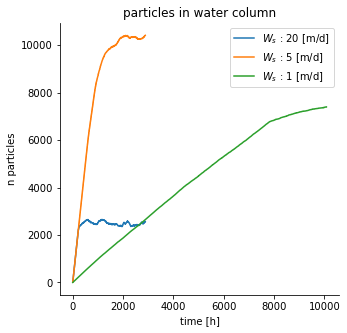

In [11]:
Time=np.linspace(0,2881,28810)
Time2=np.linspace(0,10082,10082)
fig,ax=plt.subplots(1,figsize=(5,5))
plt.plot(Time,countime,label='$W_s$ : 20 [m/d]')
plt.plot(Time,countime1,label='$W_s$ : 5 [m/d]')
plt.plot(Time2,countime2,label='$W_s$ : 1 [m/d]')
plt.legend()
plt.xlabel('time [h]')
plt.ylabel('n particles')
plt.title('particles in water column')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Text(0.5, 1.0, 'Particles in the watercolumn')

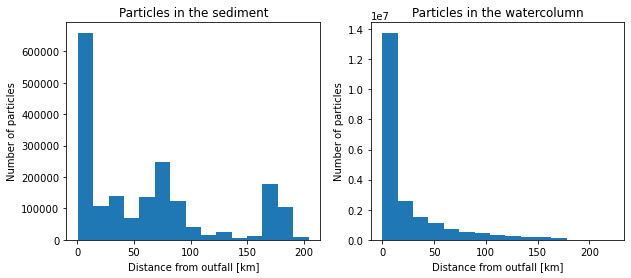

In [12]:
fig,axs=plt.subplots(1,2,figsize=(10,4))
axs[0].hist(dsink/1e3, bins = 15)
axs[0].set_xlabel('Distance from outfall [km]')
axs[0].set_ylabel('Number of particles')
axs[0].set_title('Particles in the sediment')

axs[1].hist(dcol/1e3, bins = 15)
axs[1].set_xlabel('Distance from outfall [km]')
axs[1].set_ylabel('Number of particles')
axs[1].set_title('Particles in the watercolumn')

Text(0.05, 0.5, 'Latitude')

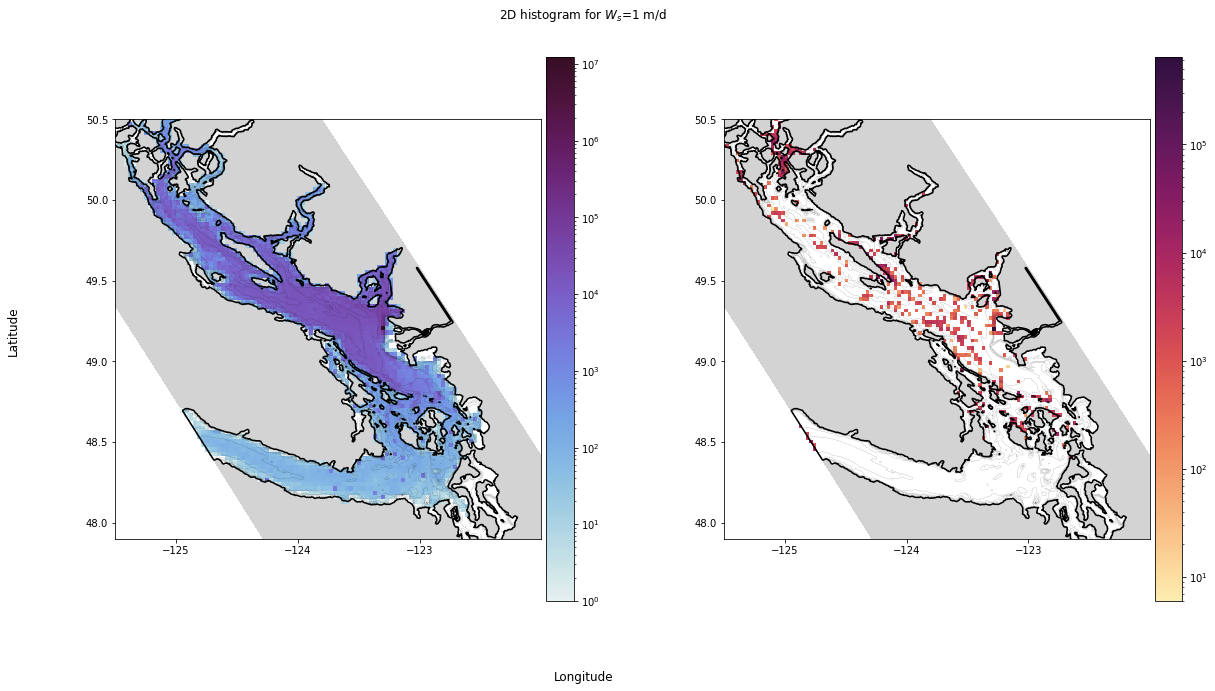

In [18]:
cm = cmocean.cm.dense

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))
ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

ax2.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax2.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax2.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

aa=ax1.hist2d(Collon,Collat,100,norm = colors.LogNorm(), cmap =cm)
cb2=fig.colorbar(aa[3],ax=ax1,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15

ax1.set_xlim([-125.5,-122])
ax1.set_ylim([47.9,50.5])
aa2=ax2.hist2d(Sedlon,Sedlat,100,norm = colors.LogNorm(), cmap =cmocean.cm.matter)
ax2.set_xlim([-125.5,-122])
ax2.set_ylim([47.9,50.5])
cb2=fig.colorbar(aa2[3],ax=ax2,pad=0.01)
cb2.ax.get_yaxis().labelpad = 15
ax1.set_xticks(np.arange(-125, -122, step=1))
ax2.set_xticks(np.arange(-125, -122, step=1))
ax1.set_aspect(1/np.sin(np.deg2rad(49)))
ax2.set_aspect(1/np.sin(np.deg2rad(49)))


fig.suptitle(f'2D histogram for $W_s$={int(WS*86400)} m/d',y=0.95,x=0.45)
fig.supxlabel('Longitude',x=0.45)
fig.supylabel('Latitude',x=0.05)

In [15]:
# #Green Particles are on the sediment
# fig, axs = plt.subplots(2,2,figsize=(10, 10))
# visuald(axs[:,0],outfile,N,n,clon,clat,dmin,dd,300,301,local)
# visuald(axs[:,1],outfile,N,n,clon,clat,dmin,dd,2800,2801,local)
# fig.suptitle(f'Particles location for $W_s$={int(WS*86400)} m/d on Jan13 and Apr26',y=0.95,x=0.45)
# fig.supxlabel('Longitude',x=0.45)

In [ ]:
#profile(N,n,100,outfile,local)

In [ ]:
#anim=mapanimation(outfile,N,n,clon,clat,1,0)
#anim

In [ ]:
# fps=240
# anim = mapanimation(outfile,N,n,clon,clat,fps,local)
# f = r"/home/jvalenti/MOAD/animations/fibreS1.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [ ]:
# with open(f,'rb') as anim:
#    display(Image(anim.read()))